In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.Resize((64, 64)),
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      ), batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.Resize((64, 64)),
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     ), batch_size=64, shuffle=False, pin_memory=True)
}

Files already downloaded and verified


In [ ]:
def block(c_in, c_out, k=5, p=0, s=2, pk=2, ps=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

# def block2(c_in, c_out, k=5, p=3, s=2, pk=2, ps=1):
#     return torch.nn.Sequential(
#         torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
#         torch.nn.ReLU(),
#         torch.nn.MaxPool2d(pk, stride=ps)
#     )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 784)
    self.conv2 = block(784, 392)
    self.conv3 = block(392, 196)
    self.conv4 = block(196, 64, p=3)
    self.fc = torch.nn.Linear(64 * 2 * 2, n_outputs)

  # def forward(self, x):
  #   print("Dimensiones:")
  #   print("Entrada: ", x.shape)
  #   x = self.conv1(x)
  #   print("conv1: ", x.shape)
  #   x = self.conv2(x)
  #   print("conv2: ", x.shape)
  #   x = self.conv3(x)
  #   print("conv3: ", x.shape)
  #   x = self.conv4(x)
  #   print("conv4: ", x.shape)
  #   x = x.view(x.shape[0], -1)
  #   print("pre fc: ", x.shape)
  #   x = self.fc(x)
  #   print("Salida: ", x.shape)
  #   return x
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [ ]:
model = CNN()

output = model(torch.randn(128, 3, 64, 64))

In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model = CNN()
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 784, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(784, 392, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(392, 196, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(196, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
fit(model, dataloader, epochs=50)

val_loss 1.59959 val_acc 0.42645: 100%|██████████| 157/157 [00:12<00:00, 12.89it/s]


Epoch 1/50 loss 1.85208 val_loss 1.59959 acc 0.32019 val_acc 0.42645


val_loss 1.44348 val_acc 0.48278: 100%|██████████| 157/157 [00:12<00:00, 12.76it/s]


Epoch 2/50 loss 1.51601 val_loss 1.44348 acc 0.45500 val_acc 0.48278


val_loss 1.34970 val_acc 0.52140: 100%|██████████| 157/157 [00:12<00:00, 12.85it/s]


Epoch 3/50 loss 1.39011 val_loss 1.34970 acc 0.50314 val_acc 0.52140


val_loss 1.28250 val_acc 0.54807: 100%|██████████| 157/157 [00:12<00:00, 12.82it/s]


Epoch 4/50 loss 1.30779 val_loss 1.28250 acc 0.53858 val_acc 0.54807


val_loss 1.22722 val_acc 0.57016: 100%|██████████| 157/157 [00:12<00:00, 12.84it/s]


Epoch 5/50 loss 1.24698 val_loss 1.22722 acc 0.56296 val_acc 0.57016


val_loss 1.20742 val_acc 0.57126: 100%|██████████| 157/157 [00:12<00:00, 12.78it/s]


Epoch 6/50 loss 1.19549 val_loss 1.20742 acc 0.58400 val_acc 0.57126


val_loss 1.16063 val_acc 0.59664: 100%|██████████| 157/157 [00:12<00:00, 12.86it/s]


Epoch 7/50 loss 1.15497 val_loss 1.16063 acc 0.59657 val_acc 0.59664


val_loss 1.16151 val_acc 0.59574: 100%|██████████| 157/157 [00:12<00:00, 12.80it/s]


Epoch 8/50 loss 1.11447 val_loss 1.16151 acc 0.61333 val_acc 0.59574


val_loss 1.11075 val_acc 0.61425: 100%|██████████| 157/157 [00:12<00:00, 12.83it/s]


Epoch 9/50 loss 1.07567 val_loss 1.11075 acc 0.62758 val_acc 0.61425


val_loss 1.06877 val_acc 0.62828: 100%|██████████| 157/157 [00:12<00:00, 12.72it/s]


Epoch 10/50 loss 1.04737 val_loss 1.06877 acc 0.63731 val_acc 0.62828


val_loss 1.06858 val_acc 0.62470: 100%|██████████| 157/157 [00:12<00:00, 12.83it/s]


Epoch 11/50 loss 1.01805 val_loss 1.06858 acc 0.65040 val_acc 0.62470


val_loss 1.03630 val_acc 0.64660: 100%|██████████| 157/157 [00:12<00:00, 12.81it/s]


Epoch 12/50 loss 0.98958 val_loss 1.03630 acc 0.65863 val_acc 0.64660


val_loss 1.02704 val_acc 0.64530: 100%|██████████| 157/157 [00:12<00:00, 12.87it/s]


Epoch 13/50 loss 0.96495 val_loss 1.02704 acc 0.66706 val_acc 0.64530


val_loss 0.98724 val_acc 0.65824: 100%|██████████| 157/157 [00:12<00:00, 12.81it/s]


Epoch 14/50 loss 0.94413 val_loss 0.98724 acc 0.67587 val_acc 0.65824


val_loss 1.00164 val_acc 0.65715: 100%|██████████| 157/157 [00:12<00:00, 12.40it/s]


Epoch 15/50 loss 0.91753 val_loss 1.00164 acc 0.68384 val_acc 0.65715


val_loss 0.97648 val_acc 0.66451: 100%|██████████| 157/157 [00:12<00:00, 12.68it/s]


Epoch 16/50 loss 0.90272 val_loss 0.97648 acc 0.69022 val_acc 0.66451


val_loss 1.00576 val_acc 0.64749: 100%|██████████| 157/157 [00:12<00:00, 12.77it/s]


Epoch 17/50 loss 0.87835 val_loss 1.00576 acc 0.69865 val_acc 0.64749


val_loss 0.97935 val_acc 0.66690: 100%|██████████| 157/157 [00:12<00:00, 12.62it/s]


Epoch 18/50 loss 0.86383 val_loss 0.97935 acc 0.70458 val_acc 0.66690


val_loss 0.93214 val_acc 0.68004: 100%|██████████| 157/157 [00:12<00:00, 12.67it/s]


Epoch 19/50 loss 0.84272 val_loss 0.93214 acc 0.71314 val_acc 0.68004


val_loss 0.95110 val_acc 0.67058: 100%|██████████| 157/157 [00:12<00:00, 12.60it/s]


Epoch 20/50 loss 0.82661 val_loss 0.95110 acc 0.71849 val_acc 0.67058


val_loss 0.91965 val_acc 0.68551: 100%|██████████| 157/157 [00:12<00:00, 12.70it/s]


Epoch 21/50 loss 0.80617 val_loss 0.91965 acc 0.72646 val_acc 0.68551


val_loss 0.90881 val_acc 0.69138: 100%|██████████| 157/157 [00:12<00:00, 12.78it/s]


Epoch 22/50 loss 0.79844 val_loss 0.90881 acc 0.72692 val_acc 0.69138


val_loss 0.90142 val_acc 0.69198: 100%|██████████| 157/157 [00:12<00:00, 12.98it/s]


Epoch 23/50 loss 0.77662 val_loss 0.90142 acc 0.73529 val_acc 0.69198


val_loss 0.91905 val_acc 0.68561: 100%|██████████| 157/157 [00:12<00:00, 12.87it/s]


Epoch 24/50 loss 0.76430 val_loss 0.91905 acc 0.73901 val_acc 0.68561


val_loss 0.91550 val_acc 0.69178: 100%|██████████| 157/157 [00:12<00:00, 12.89it/s]


Epoch 25/50 loss 0.75268 val_loss 0.91550 acc 0.74289 val_acc 0.69178


val_loss 0.94771 val_acc 0.67904: 100%|██████████| 157/157 [00:12<00:00, 12.85it/s]


Epoch 26/50 loss 0.73679 val_loss 0.94771 acc 0.75064 val_acc 0.67904


val_loss 0.88611 val_acc 0.70094: 100%|██████████| 157/157 [00:12<00:00, 12.47it/s]


Epoch 27/50 loss 0.72365 val_loss 0.88611 acc 0.75316 val_acc 0.70094


val_loss 0.90323 val_acc 0.69068: 100%|██████████| 157/157 [00:12<00:00, 12.62it/s]


Epoch 28/50 loss 0.71044 val_loss 0.90323 acc 0.75745 val_acc 0.69068


val_loss 0.87095 val_acc 0.70273: 100%|██████████| 157/157 [00:12<00:00, 12.65it/s]


Epoch 29/50 loss 0.69591 val_loss 0.87095 acc 0.76559 val_acc 0.70273


val_loss 0.87909 val_acc 0.70332: 100%|██████████| 157/157 [00:12<00:00, 12.56it/s]


Epoch 30/50 loss 0.68381 val_loss 0.87909 acc 0.76856 val_acc 0.70332


val_loss 0.86673 val_acc 0.70780: 100%|██████████| 157/157 [00:12<00:00, 12.43it/s]


Epoch 31/50 loss 0.66905 val_loss 0.86673 acc 0.77364 val_acc 0.70780


val_loss 0.89684 val_acc 0.69745: 100%|██████████| 157/157 [00:12<00:00, 12.65it/s]


Epoch 32/50 loss 0.65746 val_loss 0.89684 acc 0.77805 val_acc 0.69745


val_loss 0.90666 val_acc 0.68859: 100%|██████████| 157/157 [00:12<00:00, 12.64it/s]


Epoch 33/50 loss 0.65027 val_loss 0.90666 acc 0.78053 val_acc 0.68859


val_loss 0.86662 val_acc 0.70740: 100%|██████████| 157/157 [00:12<00:00, 12.52it/s]


Epoch 34/50 loss 0.63566 val_loss 0.86662 acc 0.78563 val_acc 0.70740


val_loss 0.93104 val_acc 0.68740: 100%|██████████| 157/157 [00:12<00:00, 12.58it/s]


Epoch 35/50 loss 0.62093 val_loss 0.93104 acc 0.78972 val_acc 0.68740


val_loss 0.84421 val_acc 0.71059: 100%|██████████| 157/157 [00:12<00:00, 12.58it/s]


Epoch 36/50 loss 0.61075 val_loss 0.84421 acc 0.79452 val_acc 0.71059


val_loss 0.86073 val_acc 0.70900: 100%|██████████| 157/157 [00:12<00:00, 12.61it/s]


Epoch 37/50 loss 0.59703 val_loss 0.86073 acc 0.79905 val_acc 0.70900


val_loss 0.86398 val_acc 0.70661: 100%|██████████| 157/157 [00:12<00:00, 12.65it/s]


Epoch 38/50 loss 0.58621 val_loss 0.86398 acc 0.80343 val_acc 0.70661


val_loss 0.89068 val_acc 0.69725: 100%|██████████| 157/157 [00:12<00:00, 12.38it/s]


Epoch 39/50 loss 0.57834 val_loss 0.89068 acc 0.80653 val_acc 0.69725


val_loss 0.84198 val_acc 0.71795: 100%|██████████| 157/157 [00:12<00:00, 12.80it/s]


Epoch 40/50 loss 0.56580 val_loss 0.84198 acc 0.81132 val_acc 0.71795


val_loss 0.86480 val_acc 0.71019: 100%|██████████| 157/157 [00:12<00:00, 12.74it/s]


Epoch 41/50 loss 0.55772 val_loss 0.86480 acc 0.81248 val_acc 0.71019


val_loss 0.83374 val_acc 0.72124: 100%|██████████| 157/157 [00:12<00:00, 12.66it/s]


Epoch 42/50 loss 0.54600 val_loss 0.83374 acc 0.81650 val_acc 0.72124


val_loss 0.85945 val_acc 0.71198: 100%|██████████| 157/157 [00:12<00:00, 12.42it/s]


Epoch 43/50 loss 0.53401 val_loss 0.85945 acc 0.82047 val_acc 0.71198


val_loss 0.85891 val_acc 0.71726: 100%|██████████| 157/157 [00:12<00:00, 12.48it/s]


Epoch 44/50 loss 0.52272 val_loss 0.85891 acc 0.82373 val_acc 0.71726


val_loss 0.85244 val_acc 0.71517: 100%|██████████| 157/157 [00:12<00:00, 12.58it/s]


Epoch 45/50 loss 0.51171 val_loss 0.85244 acc 0.83002 val_acc 0.71517


val_loss 0.85163 val_acc 0.71965: 100%|██████████| 157/157 [00:12<00:00, 12.54it/s]


Epoch 46/50 loss 0.50394 val_loss 0.85163 acc 0.83228 val_acc 0.71965


val_loss 0.87972 val_acc 0.70939: 100%|██████████| 157/157 [00:12<00:00, 12.42it/s]


Epoch 47/50 loss 0.49048 val_loss 0.87972 acc 0.83744 val_acc 0.70939


val_loss 0.86524 val_acc 0.71616: 100%|██████████| 157/157 [00:12<00:00, 12.53it/s]


Epoch 48/50 loss 0.48366 val_loss 0.86524 acc 0.83961 val_acc 0.71616


val_loss 0.85869 val_acc 0.71646: 100%|██████████| 157/157 [00:12<00:00, 12.51it/s]


Epoch 49/50 loss 0.47438 val_loss 0.85869 acc 0.84263 val_acc 0.71646


val_loss 0.86971 val_acc 0.71746: 100%|██████████| 157/157 [00:12<00:00, 12.63it/s]

Epoch 50/50 loss 0.46326 val_loss 0.86971 acc 0.84653 val_acc 0.71746


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(model, dataloader, r, c):
    model.to('cuda')
    with torch.no_grad():
        for loader_name, test_loader in dataloader.items():
            if loader_name == 'train':
                continue
            # Mostrar las primeras imágenes del primer lote del DataLoader de prueba
            fig = plt.figure(figsize=(2*c, 2*r))
            for batch_idx, (data, target) in enumerate(test_loader):
                if batch_idx == 0:
                    data = data.to('cuda')
                    target = target.to('cuda')
                    output = model(data)
                    predictions = output.argmax(dim=1)
                    for i in range(r * c):
                        plt.subplot(r, c, i + 1)
                        img = data[i].cpu().numpy().transpose(1, 2, 0)
                        y_true = target[i].item()
                        y_pred = predictions[i].item()
                        plt.imshow(img, cmap='gray')
                        plt.axis("off")
                        #plt.title(f"{y_true}/{y_pred}", color="green" if y_true == y_pred else "red")
                        plt.title(f"{classes[y_true]}/{classes[y_pred]}", color="green" if y_true == y_pred else "red")
                        plt.tight_layout()
                    plt.show()
                    break

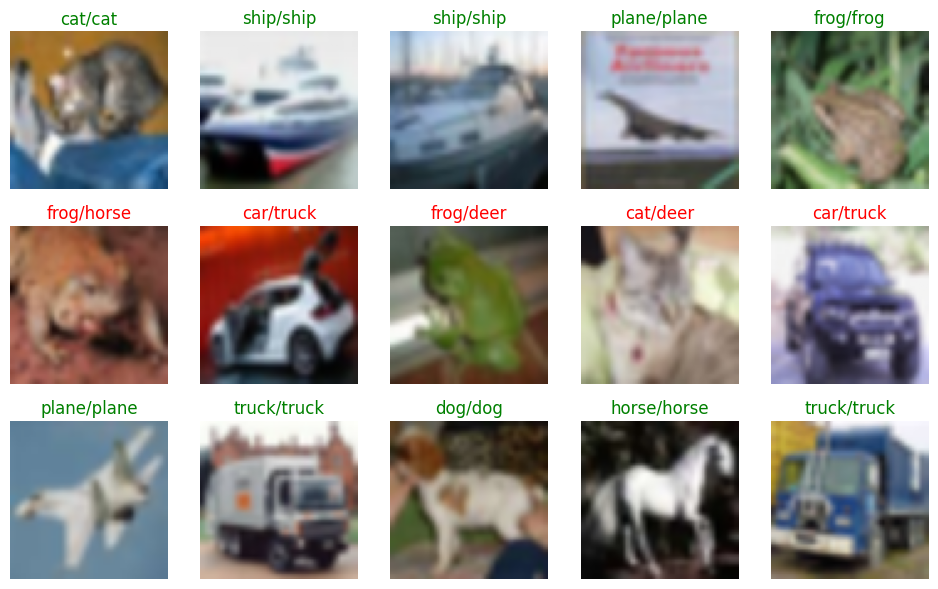

In [ ]:
plot_predictions(model, dataloader, 3, 5)